# 4 imputs (N,Z,uq,dq) and two outputs (Mass excess, seperation energey) in single ANN

# Imports

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)
print(now)

C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-2-outputs
2019-08-20-16-00-28


In [2]:
#%matplotlib notebook

# Read the data set

In [3]:
df = pd.read_csv("better-nuclei-19-08.csv")
print(df.info())
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
Z                                  3436 non-null int64
N                                  3436 non-null int64
UQ                                 3436 non-null int64
DQ                                 3436 non-null int64
Mass Excess [MeV]                  3436 non-null float64
Mass Error                         3436 non-null float64
Mass Estimated                     3436 non-null int64
Neutron separation energy [MeV]    3318 non-null float64
Separation Error                   3318 non-null float64
Separation Estimated               3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


Index(['Z', 'N', 'UQ', 'DQ', 'Mass Excess [MeV]', 'Mass Error',
       'Mass Estimated', 'Neutron separation energy [MeV]', 'Separation Error',
       'Separation Estimated'],
      dtype='object')

In [4]:
df = df.rename(columns=
               {"Mass Excess [MeV]": "d",
                "Z":'z',
                'N':'n',
                'UQ':"uq",
                'DQ':"dq",
                "Mass Error":"mass error",
                "Mass Estimated":"mass estimated",
                "Neutron separation energy [MeV]":"d2",
                "Separation Error":"separation error",
                "Separation Estimated":"separation estimated"               
               })
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
z                       3436 non-null int64
n                       3436 non-null int64
uq                      3436 non-null int64
dq                      3436 non-null int64
d                       3436 non-null float64
mass error              3436 non-null float64
mass estimated          3436 non-null int64
d2                      3318 non-null float64
separation error        3318 non-null float64
separation estimated    3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


In [5]:
df.describe()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
count,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3318.000000,3318.000000,3318.000000
mean,57.857392,82.034051,197.748836,221.925495,-24.144121,0.123589,0.272992,7.755557,0.164216,0.295660
std,27.809406,43.293558,98.188326,113.771063,56.200706,0.197548,0.445562,3.631747,0.254378,0.456408
min,0.000000,0.000000,1.000000,1.000000,-91.652853,0.000000,0.000000,-2.488000,0.000000,0.000000
25%,36.000000,47.000000,120.750000,131.000000,-65.400443,0.003006,0.000000,5.414787,0.005140,0.000000
50%,58.000000,81.000000,197.000000,219.000000,-39.335024,0.014474,0.000000,7.249960,0.025005,0.000000
75%,80.000000,114.000000,273.000000,308.000000,1.172301,0.196000,1.000000,9.654658,0.269058,1.000000
max,118.000000,177.000000,413.000000,472.000000,201.512000,2.003000,1.000000,27.715000,2.011000,1.000000


# Remove estimated Excess and estimated Seperation

In [6]:
not_estimated_filter = (df["mass estimated"] == 0)
df = df[not_estimated_filter]

not_estimated_filter = (df["separation estimated"] == 0)
df = df[not_estimated_filter]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


In [8]:
df.isnull().values.any()

False

In [9]:
df['z'].shape

(2337,)

In [10]:
df.count()

z                       2337
n                       2337
uq                      2337
dq                      2337
d                       2337
mass error              2337
mass estimated          2337
d2                      2337
separation error        2337
separation estimated    2337
dtype: int64

In [11]:
df.head()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
0,0,1,1,2,8.071317,4.000000e-07,0,0.00000,0.00000,0.0
2,1,1,3,3,13.135722,1.000000e-07,0,2.22457,0.00000,0.0
3,1,2,4,5,14.949810,2.000000e-07,0,6.25723,0.00000,0.0
4,1,3,5,7,24.621127,1.000000e-01,0,-1.60000,0.10000,0.0
5,1,4,6,9,32.892444,8.944300e-02,0,-0.20000,0.13416,0.0


# Plot seperation energy column

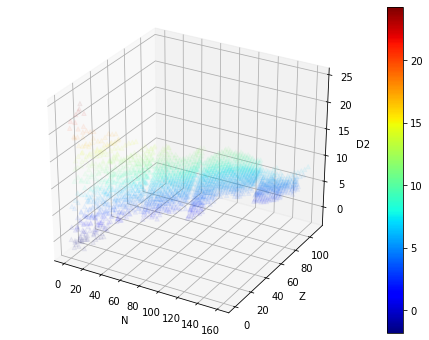

In [12]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d2']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D2')


plt.show()

In [13]:
df['d2'].to_numpy().shape

(2337,)

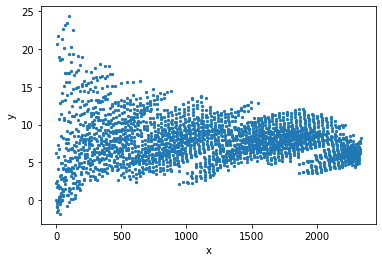

In [14]:
plt.scatter(range(df['d2'].count()), df['d2'].to_numpy(), s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Dividing Mass Excess by A = Z + N

In [15]:
zes = df['z'].to_numpy()
ns = df['n'].to_numpy()
a = zes + ns

des = df['d'].to_numpy() / a
df['d'] = des


# Plot Mass excess output column

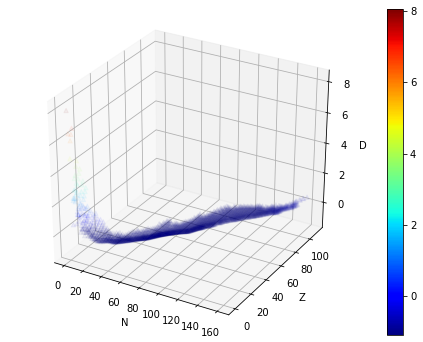

In [16]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Tripcolor

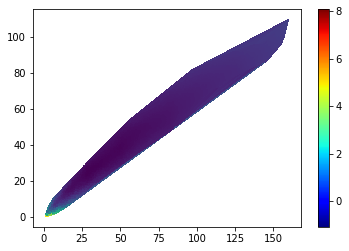

In [17]:
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

#yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)


fig, (ax)=plt.subplots(ncols=1)
ax.tripcolor(df["n"], df["z"], df["d"])
cb = fig.colorbar(colmap)

plt.show()

# Set X inputs

In [18]:
x = df[['z','n','dq','uq']]
print(x.info())
x = x.to_numpy()
print(x.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 4 columns):
z     2337 non-null int64
n     2337 non-null int64
dq    2337 non-null int64
uq    2337 non-null int64
dtypes: int64(4)
memory usage: 91.3 KB
None
(2337, 4)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


# Set Y inputs _(HERE CHANGE NUMBER OF INPUTS AND RESHAPE)

In [20]:
y = df[['d','d2']].to_numpy() #HERE
y.shape

(2337, 2)

In [21]:
y = y.reshape(-1,2) #HERE
y.shape

(2337, 2)

In [22]:
y[0:5]

array([[ 8.07131713,  0.        ],
       [ 6.56786088,  2.22457   ],
       [ 4.98326998,  6.25723   ],
       [ 6.15528175, -1.6       ],
       [ 6.5784888 , -0.2       ]])

# Prepare X_train_o, Y_train_o etc

In [23]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.2, random_state=1)
X_train_o, X_val_o, y_train_o, y_val_o  = train_test_split(X_train_o, y_train_o, test_size=0.2, random_state=1)
n_inputs = X_train_o.shape[1]
n_outputs = y_train_o.shape[1]
print(n_inputs)
print(n_outputs)
print(X_train_o.shape, X_test_o.shape,X_val_o.shape)

4
2
(1495, 4) (468, 4) (374, 4)


# Scaling

In [24]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_o.reshape(-1, n_inputs))
X_test = x_scaler.transform(X_test_o.reshape(-1, n_inputs))
X_val = x_scaler.transform(X_val_o.reshape(-1, n_inputs))

y_train = y_scaler.fit_transform(y_train_o.reshape(-1, n_outputs))
y_test = y_scaler.transform(y_test_o.reshape(-1, n_outputs))
y_val = y_scaler.transform(y_val_o.reshape(-1, n_outputs))

n_inputs = X_train.shape[1]
n_outputs = y_train.shape[1]
print(n_inputs)
print(n_outputs)

4
2


# ANN TOPOLOGY

In [25]:
def cust_layer(inputs,number_of_neurons, name, activation=None, dropout=False):
    init = tf.initializers.he_normal(seed=None)
    hidden = tf.keras.layers.Dense(number_of_neurons,
                                   name=name,
                                    kernel_initializer=init,
                                   activation = activation,
                                   kernel_regularizer = tf.keras.regularizers.l2(l=0.1)
                                  )(inputs)
    
    batch_norm = tf.keras.layers.BatchNormalization()(hidden, training=True)
    
    if dropout:
        dropout_layer = tf.keras.layers.Dropout(0.5)(batch_norm)
        return dropout_layer
    else:
        return batch_norm
    
tf.reset_default_graph()
with tf.name_scope("dnn"):
    with tf.name_scope("inputs"):
        X_node = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y_node = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")
    
    
 
    last_layer = cust_layer(X_node,50,"hidden1")
    
    n_layers = 10
    
    for i in range(n_layers):        
        last_layer = cust_layer(last_layer,150,"hidden"+str(i),activation=tf.nn.elu,dropout=True)
    last_layer = cust_layer(last_layer,50,"hidden"+str(i+1),activation=tf.nn.elu,dropout=True)
    
    init = tf.initializers.he_normal(seed=None)    
    y_pred = tf.keras.layers.Dense(n_outputs, name="output",
                                   kernel_initializer=init)(last_layer)

    
with tf.name_scope('MSE_first_output'):
    error_f = y_pred[:,0] - y_node[:,0]
    square_f = tf.square(error_f)
    mse_f = tf.reduce_mean(square_f, name="mse_first")
    variable_summaries(mse_f)
    print(error_f.get_shape())

with tf.name_scope('MSE_second_output'):
    error_s = y_pred[:,1] - y_node[:,1]
    square_s = tf.square(error_s)
    mse_s = tf.reduce_mean(square_s, name="mse_second")
    variable_summaries(mse_s)

with tf.name_scope('MSE_combined'):
    mse = mse_f + mse_s
    variable_summaries(mse)

with tf.name_scope('optimiser'):
    optimiser = tf.train.AdamOptimizer(0.01)
    training_op = optimiser.minimize(mse)

for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)

W0820 16:00:31.139286 25860 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-2-outputs\utils.py:16: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0820 16:00:31.153867 25860 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-2-outputs\utils.py:22: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



(?,)


# File writers

In [26]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
test_writer = tf.summary.FileWriter(logdir + '/test')
valid_writer = tf.summary.FileWriter(logdir + '/valid')
init = tf.global_variables_initializer()

saver = tf.train.Saver()

checkpoint_path = os.path.join(dir_path, "sinus_tmp","sinus_full_model.ckpt")
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = os.path.join(dir_path, "model", "my_sinus_full_model")

# Number of epochs and batches

In [27]:
n_epochs = 2000
n_batches = 50

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = n_epochs * 0.2
print(max_epochs_without_progress)



400.0


# Training

In [28]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, n_batches):
            summary, _ = sess.run([merged, training_op],
                                  feed_dict={X_node: X_batch, y_node: y_batch})

        train_summary, _ = sess.run([merged, training_op],feed_dict={X_node: X_train, y_node: y_train})
        test_summary, _ =sess.run([merged, training_op],feed_dict={X_node: X_test, y_node: y_test})
        validation_summary, _ = sess.run([merged, training_op], feed_dict={X_node: X_val, y_node: y_val})

        train_writer.add_summary(train_summary, epoch)
        test_writer.add_summary(test_summary, epoch)
        valid_writer.add_summary(validation_summary,epoch)

        loss_train = mse.eval(feed_dict={X_node: X_train, y_node: y_train})
        loss_val = mse.eval(feed_dict={X_node: X_val, y_node: y_val})
        print(epoch, "train loss:", loss_train, "valid loss:", loss_val)

        iteration_skip = 10
        if epoch % iteration_skip == 0:
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

        if loss_val < best_loss:
            saver.save(sess, final_model_path)
            best_loss = loss_val
            print("best loss:", best_loss)
            epochs_without_progress = 0
        else:
            epochs_without_progress += 1
            if epochs_without_progress > max_epochs_without_progress:
                print("Early stopping")
                break


train_writer.close()
test_writer.close()
valid_writer.close()

0 train loss: 0.57694626 valid loss: 0.641177
best loss: 0.641177
1 train loss: 0.4655128 valid loss: 0.63854945
best loss: 0.63854945
2 train loss: 0.39582545 valid loss: 0.5537838
best loss: 0.5537838
3 train loss: 0.3555234 valid loss: 0.5131866
best loss: 0.5131866
4 train loss: 0.40414172 valid loss: 0.44932896
best loss: 0.44932896
5 train loss: 0.38034353 valid loss: 0.5353166
6 train loss: 0.34890893 valid loss: 0.44772303
best loss: 0.44772303
7 train loss: 0.3892638 valid loss: 0.50055075
8 train loss: 0.34821212 valid loss: 0.4262332
best loss: 0.4262332
9 train loss: 0.3241265 valid loss: 0.425375
best loss: 0.425375
10 train loss: 0.31520194 valid loss: 0.36526883
best loss: 0.36526883
11 train loss: 0.361406 valid loss: 0.43244335
12 train loss: 0.34105113 valid loss: 0.4374334
13 train loss: 0.34021196 valid loss: 0.41588175
14 train loss: 0.34661 valid loss: 0.4653055
15 train loss: 0.3707716 valid loss: 0.49516636
16 train loss: 0.41287592 valid loss: 0.5041723
17 trai

163 train loss: 0.3274149 valid loss: 0.4086993
164 train loss: 0.30890518 valid loss: 0.4334055
165 train loss: 0.2619456 valid loss: 0.3484257
166 train loss: 0.2983284 valid loss: 0.38874257
167 train loss: 0.31972706 valid loss: 0.4053251
168 train loss: 0.34686476 valid loss: 0.46031335
169 train loss: 0.28450587 valid loss: 0.34178168
170 train loss: 0.32202604 valid loss: 0.43528104
171 train loss: 0.3077308 valid loss: 0.37400433
172 train loss: 0.26080787 valid loss: 0.35714746
173 train loss: 0.3612181 valid loss: 0.43043417
174 train loss: 0.3315282 valid loss: 0.4566012
175 train loss: 0.29398203 valid loss: 0.3853722
176 train loss: 0.30406442 valid loss: 0.4293789
177 train loss: 0.26284027 valid loss: 0.32317358
178 train loss: 0.37330648 valid loss: 0.4699039
179 train loss: 0.29451382 valid loss: 0.38095915
180 train loss: 0.3998541 valid loss: 0.52530044
181 train loss: 0.35299122 valid loss: 0.42882913
182 train loss: 0.31066817 valid loss: 0.4360554
183 train loss: 

330 train loss: 0.30119464 valid loss: 0.41493967
331 train loss: 0.27250162 valid loss: 0.3419953
332 train loss: 0.29352862 valid loss: 0.39296412
333 train loss: 0.32284215 valid loss: 0.39727312
334 train loss: 0.3536546 valid loss: 0.39131653
335 train loss: 0.32977173 valid loss: 0.3835343
336 train loss: 0.28354535 valid loss: 0.3122242
337 train loss: 0.26437762 valid loss: 0.36677986
338 train loss: 0.24626642 valid loss: 0.31365606
339 train loss: 0.27190715 valid loss: 0.3129845
340 train loss: 0.4038033 valid loss: 0.42817461
341 train loss: 0.32124376 valid loss: 0.33020642
342 train loss: 0.29368222 valid loss: 0.3292926
343 train loss: 0.25282836 valid loss: 0.2978241
344 train loss: 0.26488185 valid loss: 0.3314642
345 train loss: 0.32800317 valid loss: 0.387187
346 train loss: 0.23355502 valid loss: 0.30112547
347 train loss: 0.33804435 valid loss: 0.44564685
348 train loss: 0.28328493 valid loss: 0.36886626
349 train loss: 0.2661751 valid loss: 0.28485978
350 train lo

496 train loss: 0.23840941 valid loss: 0.279092
497 train loss: 0.2420475 valid loss: 0.29166615
498 train loss: 0.22959287 valid loss: 0.295743
499 train loss: 0.28387067 valid loss: 0.2780724
500 train loss: 0.34501475 valid loss: 0.39461285
501 train loss: 0.2391979 valid loss: 0.29747358
502 train loss: 0.24944428 valid loss: 0.2705994
503 train loss: 0.7487104 valid loss: 0.6907377
504 train loss: 0.2532115 valid loss: 0.29711378
505 train loss: 0.24639817 valid loss: 0.2895163
506 train loss: 0.27934796 valid loss: 0.32312864
507 train loss: 0.24305718 valid loss: 0.29271352
508 train loss: 0.2504034 valid loss: 0.26278326
509 train loss: 0.30182323 valid loss: 0.36288467
510 train loss: 0.27942422 valid loss: 0.2810678
511 train loss: 0.24005648 valid loss: 0.28411263
512 train loss: 0.32848042 valid loss: 0.30246162
513 train loss: 0.25969177 valid loss: 0.3161462
514 train loss: 0.4102165 valid loss: 0.48728648
515 train loss: 0.26706338 valid loss: 0.31357694
516 train loss: 

662 train loss: 0.33703178 valid loss: 0.35690773
663 train loss: 0.23840266 valid loss: 0.31371498
664 train loss: 0.24218239 valid loss: 0.29257566
665 train loss: 0.25847983 valid loss: 0.30094874
666 train loss: 0.24592938 valid loss: 0.28030533
667 train loss: 0.23726985 valid loss: 0.29266417
668 train loss: 0.24686447 valid loss: 0.35350597
669 train loss: 0.34482387 valid loss: 0.34103426
670 train loss: 0.2893272 valid loss: 0.28793845
671 train loss: 0.27060834 valid loss: 0.3179495
672 train loss: 0.23669867 valid loss: 0.28267583
673 train loss: 0.24614343 valid loss: 0.32319367
674 train loss: 0.21344407 valid loss: 0.24607249
675 train loss: 0.24268916 valid loss: 0.26917008
676 train loss: 0.2514239 valid loss: 0.26445267
677 train loss: 0.25123417 valid loss: 0.28287333
678 train loss: 0.2772243 valid loss: 0.33878562
679 train loss: 0.27433753 valid loss: 0.3362868
680 train loss: 0.3340167 valid loss: 0.36051574
681 train loss: 0.2663164 valid loss: 0.33923483
682 tra

828 train loss: 0.31531876 valid loss: 0.3538771
829 train loss: 0.24384376 valid loss: 0.27909675
830 train loss: 0.25863 valid loss: 0.29417017
831 train loss: 0.24644235 valid loss: 0.31726408
832 train loss: 0.22923723 valid loss: 0.27005976
833 train loss: 0.2460821 valid loss: 0.25961256
834 train loss: 0.37748984 valid loss: 0.34793475
835 train loss: 0.24015725 valid loss: 0.26933038
836 train loss: 0.245836 valid loss: 0.2659508
837 train loss: 0.2886399 valid loss: 0.34690264
838 train loss: 0.23496903 valid loss: 0.2745017
839 train loss: 0.23935908 valid loss: 0.27196115
840 train loss: 0.22552204 valid loss: 0.26302612
841 train loss: 0.22521469 valid loss: 0.23546958
842 train loss: 0.24028425 valid loss: 0.27658194
843 train loss: 0.24425104 valid loss: 0.2623163
844 train loss: 0.3065844 valid loss: 0.323773
845 train loss: 0.24084981 valid loss: 0.26062226
846 train loss: 0.28168806 valid loss: 0.32969514
847 train loss: 0.2574817 valid loss: 0.31159753
848 train loss:

994 train loss: 0.23616098 valid loss: 0.290221
995 train loss: 0.22959223 valid loss: 0.2623764
996 train loss: 0.23705557 valid loss: 0.29455602
997 train loss: 0.27128068 valid loss: 0.37700167
998 train loss: 0.23913233 valid loss: 0.27060184
999 train loss: 0.29250506 valid loss: 0.30518764
1000 train loss: 0.26492366 valid loss: 0.34421906
1001 train loss: 0.30036074 valid loss: 0.33316052
1002 train loss: 0.2497597 valid loss: 0.33280066
1003 train loss: 0.23206216 valid loss: 0.28119445
1004 train loss: 0.22057302 valid loss: 0.24494919
1005 train loss: 0.24390832 valid loss: 0.2964284
1006 train loss: 0.25406042 valid loss: 0.3016689
1007 train loss: 0.25788507 valid loss: 0.355043
1008 train loss: 0.22723675 valid loss: 0.2678952
1009 train loss: 0.24460924 valid loss: 0.32659757
1010 train loss: 0.2648791 valid loss: 0.3439874
1011 train loss: 0.3146131 valid loss: 0.37752596
1012 train loss: 0.26475662 valid loss: 0.34932765
1013 train loss: 0.31764156 valid loss: 0.4049879

In [29]:
os.remove(checkpoint_epoch_path)

# Predictions

In [30]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    test_mse = mse.eval(feed_dict={X_node: X_test, y_node: y_test})
    predictions = y_pred.eval(feed_dict={X_node: X_test, y_node: y_test})
    
    
print(test_mse)

W0820 16:10:56.926553 25860 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.28278995


In [31]:
predictions.shape

(468, 2)

# Plot  _first (0th)_ output column of _predictions_

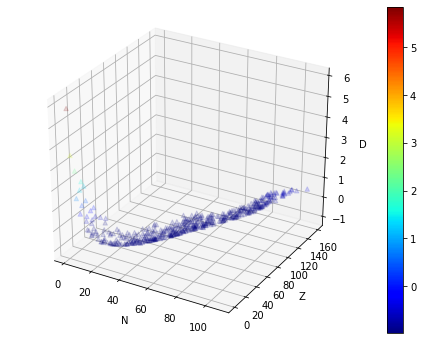

In [32]:
y_new_inverse = y_scaler.inverse_transform(predictions)
x_test_inverse = x_scaler.inverse_transform(X_test)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = y_new_inverse[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [33]:
y_test_o.shape[0]


468

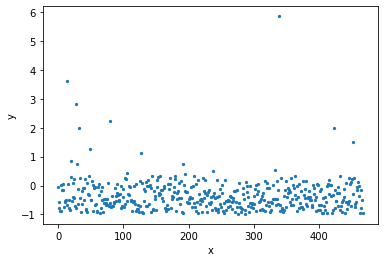

In [34]:
plt.scatter(range(y_new_inverse.shape[0]), y_new_inverse[:,0], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot _first 0th_ column of TEST set

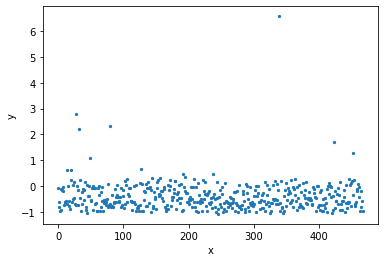

In [35]:
plt.scatter(range(y_test_o.shape[0]), y_test_o[:,0], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

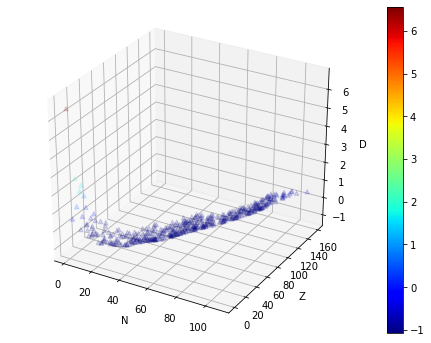

In [36]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = X_test_o[:,0]
ys = X_test_o[:,1]
zs = y_test_o[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Plot second column of Predictions 

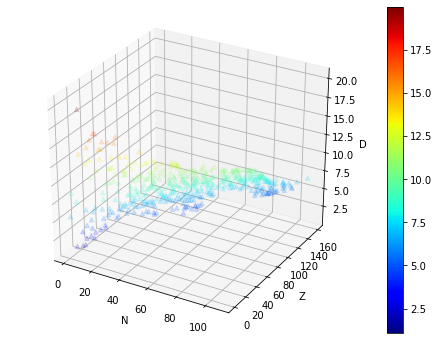

In [37]:
y_new_inverse = y_scaler.inverse_transform(predictions)
x_test_inverse = x_scaler.inverse_transform(X_test)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = y_new_inverse[:,1]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

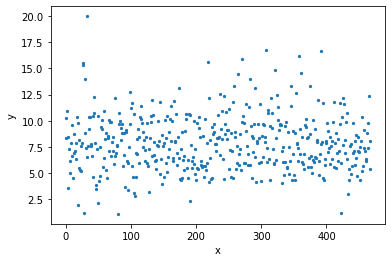

In [38]:
plt.scatter(range(y_new_inverse.shape[0]), y_new_inverse[:,1], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot second column of TEST set

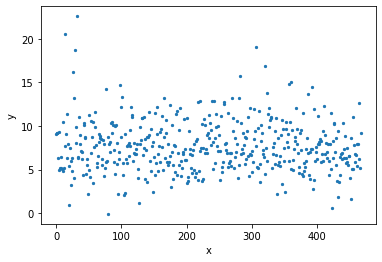

In [39]:
plt.scatter(range(y_test_o.shape[0]), y_test_o[:,1], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

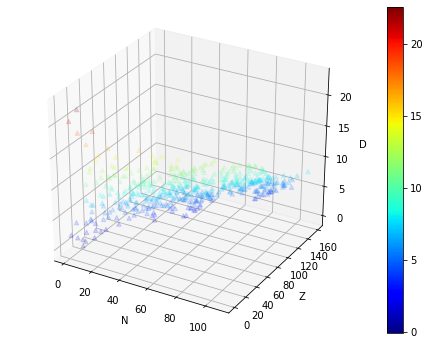

In [40]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = X_test_o[:,0]
ys = X_test_o[:,1]
zs = y_test_o[:,1]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Calculate _diff_ and _diff_abs_ (no distinction for columns)

In [41]:
#diff = np.square((y_new_inverse - y_test_o) / y_test_o)
substraction = y_new_inverse - y_test_o
diff = np.divide( substraction , y_test_o, out = substraction, where = y_test_o != 0)
diff_abs = y_new_inverse - y_test_o

In [42]:
diff_df = pd.DataFrame(data={'rel diff mass': diff[:,0],
                            'rel diff sep': diff[:,1],
                            'abs diff mass' : diff_abs[:,0],
                             'abs diff sep' : diff_abs[:,1],
                            })
diff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 4 columns):
rel diff mass    468 non-null float64
rel diff sep     468 non-null float64
abs diff mass    468 non-null float64
abs diff sep     468 non-null float64
dtypes: float64(4)
memory usage: 14.7 KB


# Replace inf and -inf with Nan, then drop the nans

In [43]:
diff_df = diff_df.replace([np.inf, -np.inf], np.nan)

In [44]:
print(diff_df.isnull().values.any())
print(diff_df.isnull().sum())
diff_df = diff_df.dropna()

False
rel diff mass    0
rel diff sep     0
abs diff mass    0
abs diff sep     0
dtype: int64


In [45]:
diff_df.describe()

,rel diff mass,rel diff sep,abs diff mass,abs diff sep
count,468.000000,468.000000,468.000000,468.000000
mean,-0.035813,0.044531,0.060454,0.212778
std,2.629134,0.720366,0.154276,1.453434
min,-48.145158,-14.250863,-0.715965,-11.841702
25%,-0.147609,-0.095417,0.032217,-0.842747
50%,-0.093693,0.044113,0.048876,0.304314
75%,-0.021586,0.192319,0.070262,1.266661
max,17.512019,3.509910,3.025219,5.842386


# Plot the relative diff of the first column

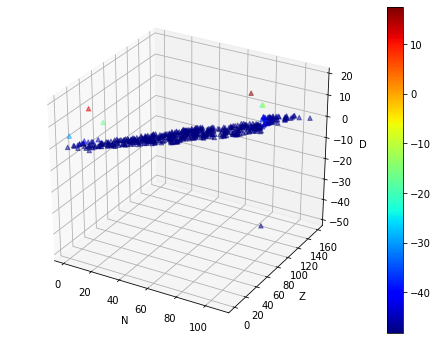

In [46]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = diff_df['rel diff mass']# diff[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.5)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [47]:
#%matplotlib notebook

In [48]:
vals = diff_df['rel diff mass'].to_numpy()
print(vals.shape)
print(vals.shape[0])

(468,)
468


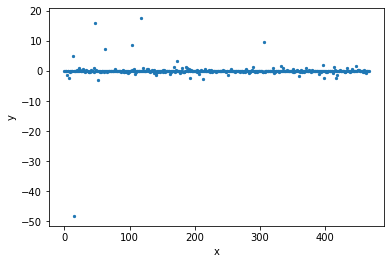

In [49]:
#plt.scatter(iterate_x, diff[:,0], s=5)

plt.scatter(range(vals.shape[0]),vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot the relative diff of the second column

In [50]:
vals = diff_df['rel diff sep'].to_numpy()
print(vals.shape)
print(vals.shape[0])

(468,)
468


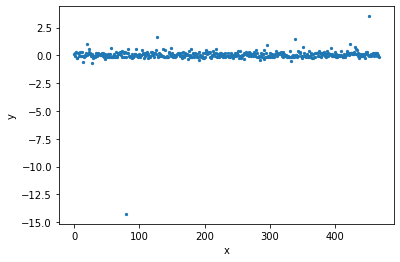

In [51]:
plt.scatter(range(vals.shape[0]), vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Diff ABSOLUTE of first column

In [52]:
vals = diff_df['abs diff mass'].to_numpy()
print(vals.shape)
range_x = range(vals.shape[0])

(468,)


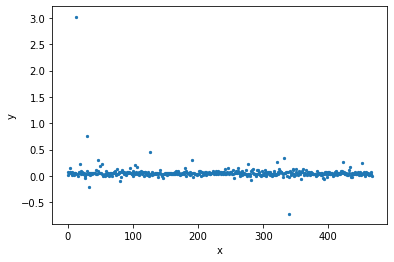

In [53]:
plt.scatter(range_x,vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Diff ABSOLUTE of second column

In [54]:
vals = diff_df['abs diff sep'].to_numpy()
print(vals.shape)
range_x = range(vals.shape[0])

(468,)


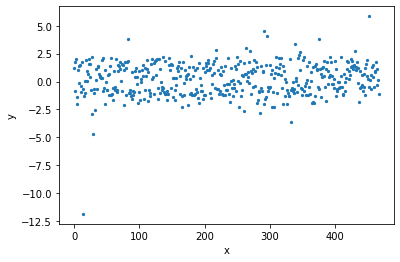

In [55]:
plt.scatter(range_x,vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()